THE PURPOSE OF THIS NOTEBOOK IS TO RECOMMEND A SONG GIVEN ANOTHER SONG.
2 APPROACHES WERE TESTED.

In [101]:
import pandas as pd
import numpy as np
import spotipy
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from spotipy.oauth2 import SpotifyClientCredentials
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from annoy import AnnoyIndex

warnings.filterwarnings('ignore')

SPOTIFY API

In [102]:
cid = 'd9219a18c2ed48e685ea287cbfcdda95'
secret = 'b9492ce5ac57427c9ee60be103779a29'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

RAW DATA

In [103]:
#THIS PART WAS EXECUTED BEFOREHAND AND IS IN COMMENT TO AVOID PUSHING ADDITIONAL CSV FILES TO THE REPOSITORY
# df_raw = pd.read_csv('spotify_data.csv')
# df_raw.drop(columns=['Unnamed: 0'], inplace=True) #THE RAW(KAGGLE) DATA IS LOADED AND THE FIRST COLUMN IS DROPPED
# df_raw

LOADING MANUALLY COLLECTED DATA AND CONCATENATING IT TO THE LARGE DATASET (SEE DATA_COLLECTION.IPYNB FOR INFO ABOUT NEW_DATA.CSV)

In [104]:
# df_new = pd.read_csv('new_data.csv')
# df_new

In [105]:
# df = pd.concat([df_raw, df_new], ignore_index=True)
# df

DROPPING ROWS WHERE TRACK_NAME AND ARTIST_NAME CONTAIN MISSING VALUES (NaN)

In [106]:
# df = df.dropna(subset=['track_name'])
# df = df.dropna(subset=['artist_name'])
# df

LANGUAGE CLASSIFICATION FUNCTION

In [107]:
def classify_language(text): #this simple function detects the langauge of the song based on the characters in its title, not perfect but enough since it's not the main focus
    if any(char in text.lower() for char in ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ']):
        return 0
    elif any(char in text.lower() for char in ['あ', 'い', 'う', 'え', 'お', 'か', 'き', 'く', 'け', 'こ']):
        return 1
    elif 'ñ' in text:
        return 2
    elif any(char in text.lower() for char in ['é', 'è', 'à', 'ù', 'ì', 'ò']):
        return 3
    elif any(char in text.lower() for char in ['ə', 'ğ']):
        return 4
    elif any(char in text.lower() for char in [
        'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 
        'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 
        'ъ', 'ы', 'ь', 'э', 'ю', 'я']):
        return 5
    return 6

# df['language'] = df['track_name'].apply(classify_language)

SAVING THE FINAL VERSION OF THE DATA

In [108]:
# df.to_csv('final_data.csv', index=False)

LOADING THE FINAL DATASET

In [109]:
df = pd.read_csv(r'C:\Users\msi thin\Desktop\recommender\final_data.csv')
df

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,language
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3,6
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4,6
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4,6
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4,6
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160193,Kanye West,I Love It (& Lil Pump),4S8d14HvHb70ImctNgVzQQ,72,2018,chicago rap,0.901,0.522,2,-8.304,1,0.3300,0.0114,0.000000,0.2590,0.329,104.053,127946,4,6
1160194,Rihanna,FourFiveSeconds,78TTtXnFQPzwqlbtbwqN0y,80,2015,pop,0.582,0.272,2,-5.662,1,0.0501,0.8750,0.000000,0.1300,0.354,205.846,188238,4,6
1160195,Kanye West,FML,30Zcjs7pgEkmJA1lEbGSWT,64,2016,rap,0.527,0.415,5,-7.184,1,0.1310,0.3290,0.000000,0.1950,0.120,125.357,236120,4,6
1160196,¥$,PAPERWORK,2yyO7EKRr7c3txi4xCXUFk,77,2024,chicago rap,0.741,0.488,8,-5.308,1,0.0556,0.0703,0.000009,0.0821,0.186,120.839,145785,4,6


ENCODING & SCALING

In [110]:
label_encoder = LabelEncoder()
# df = pd.get_dummies(df, columns=['genre'], prefix=['genre'], dtype=int) - IF ONE HOT ENCODING WAS USED
df['genre_encoded'] = label_encoder.fit_transform(df['genre'])

#these features were chosen by testing the impact of each one
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 
            'time_signature', 'popularity', 'genre_encoded', 'language']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features]) #we can see that the values are scaled & encoded
# features += [col for col in df.columns if 'genre' in col] - IF ONE HOT ENCODING WAS USED

In [111]:
df[features]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,genre_encoded,language
0,0.486405,0.303,0.747479,0.044181,0.696787,0.000000,0.1150,0.139,0.533639,0.6,0.68,0.000000,1.0
1,0.576032,0.454,0.743932,0.026571,0.478916,0.000014,0.0974,0.515,0.560744,0.8,0.50,0.000000,1.0
2,0.411883,0.234,0.690643,0.033265,0.339357,0.000050,0.0895,0.145,0.559344,0.8,0.57,0.000000,1.0
3,0.394763,0.251,0.750794,0.037384,0.810241,0.000000,0.0797,0.508,0.819867,0.8,0.58,0.000000,1.0
4,0.433031,0.791,0.819657,0.031102,0.072892,0.019300,0.1100,0.217,0.687475,0.8,0.54,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160193,0.907351,0.522,0.774770,0.339856,0.011446,0.000000,0.2590,0.329,0.416224,0.8,0.72,0.096491,1.0
1160194,0.586103,0.272,0.815876,0.051596,0.878514,0.000000,0.1300,0.354,0.823407,0.8,0.80,0.631579,1.0
1160195,0.530715,0.415,0.792196,0.134912,0.330321,0.000000,0.1950,0.120,0.501442,0.8,0.64,0.692982,1.0
1160196,0.746224,0.488,0.821384,0.057261,0.070582,0.000009,0.0821,0.186,0.483370,0.8,0.77,0.096491,1.0


CREATING THE FEATURE MATRIX

In [112]:
df['song_vector'] = df[features].values.tolist() #we store these values in the dataframe for later use
song_matrix = df[features].values #this matrix is used to calculate cosine similarity
song_norms = np.linalg.norm(song_matrix, axis=1) #this vector is used to calculate cosine similarity
song_matrix.shape, song_norms.shape

((1160198, 13), (1160198,))

FETCHING UNKNOWN SONG FEATURES

In [113]:
def unknown_song_vector(id): #this function is used to fetch the audio features of a song which was not found in the database
    try: #fetching the audio features of the song
        results = sp.audio_features(id)
        audio_data = [
            results[0]['danceability'],
            results[0]['energy'],
            results[0]["loudness"],
            results[0]['speechiness'],
            results[0]['acousticness'],
            results[0]['instrumentalness'],
            results[0]['liveness'],
            results[0]['valence'],
            results[0]['tempo'],
            results[0]['time_signature'],
            sp.track(id)['popularity']
        ]
    except Exception as e:  #this exception may be useful if the song in playlist is not available in spotify's database, i.e. a local file
        print('EXCEPTION: Could not retrieve audio features for this song', e)
        return 
    
    genres = sp.artist(sp.track(id)['artists'][0]['id'])['genres'] #fetching the genre of the song

    if len(genres) == 0: 
        genre_encoded = 72 #if no genre is found, we use the default genre 'pop'
    else:
        genre_candidates = []
        for genre in genres:
            try:
                genre_encoded = label_encoder.transform([genre])[0] #encoding the genres 
                genre_candidates.append(genre_encoded)
            except ValueError:
                pass
        if genre_candidates: #if the genre is found, we take the average of the genres
            genre_encoded = np.mean(genre_candidates)
        else:
            genre_encoded = 72 #if the genre is not found, we use the default genre 'pop'

    language = classify_language(sp.track(id)['name'])
    
    audio_data.append(genre_encoded)
    audio_data.append(language)
    audio_data = np.array(audio_data).reshape(1, -1)
    audio_data = scaler.transform(audio_data)

    return audio_data[0]

SONG SEARCH USING SPOTIFY'S API

In [114]:
search_query = "after hours the weeknd"

try:
    results = sp.search(q=search_query, limit=1)
    id = results['tracks']['items'][0]['id']
    song_name = results['tracks']['items'][0]['name']
    artist_name = results['tracks']['items'][0]['artists'][0]['name']
    print(song_name, artist_name)
    
except IndexError:
    print("EXCEPTION: Song not found on Spotify.")

After Hours The Weeknd


RECOMMENDING SIMILAR SONGS (USING COSINE SIMILARITY)

In [115]:
#if the song is found in the dataset, we use the song vector from the dataset
#else we fetch the song vector using the unknown_song_vector function
try:
    input_song_vector = np.array(df[df['track_id'] == id]['song_vector'].values[0])
    print('Song vector retrieved from the dataset.')
except IndexError:
    input_song_vector = unknown_song_vector(id)
    print('Song vector retrieved from using API & unknown_song_vector function.')

TOP = 20 #number of songs to recommend
similarities = np.dot(song_matrix, input_song_vector) / (song_norms * np.linalg.norm(input_song_vector)) #calculating cosine similarity between the input song and the songs in the dataset
sorted_indices = np.argsort(similarities)[::-1][:TOP] #sorting the song indices based on similarity
top_songs = df.loc[sorted_indices, ['track_name', 'artist_name', 'track_id']] #fetching the top songs
top_songs['similarity'] = similarities[sorted_indices] #adding the similarity values

#the code below is used to fetch the mp3, spotify and image urls of the top songs
mp3_urls = []
spotify_urls = []
image_urls = []
ids = top_songs['track_id'].tolist()
results = sp.tracks(ids)

for track in results['tracks']:
    mp3_urls.append(track['preview_url'])
    spotify_urls.append(track['external_urls']['spotify'])
    image_urls.append(track['album']['images'][0]['url'])
    
top_songs['mp3_url'] = mp3_urls
top_songs['spotify_url'] = spotify_urls
top_songs['image_url'] = image_urls

#this part is used to add the input song to the top songs
#this is useful to see the input song itself in the recommendations as well
if id not in ids:
    new_song = pd.DataFrame([{
        'track_name': sp.track(id)['name'],
        'artist_name': sp.track(id)['artists'][0]['name'],
        'track_id': id,
        'similarity': 1,
        'mp3_url': sp.track(id)['preview_url'],
        'spotify_url': sp.track(id)['external_urls']['spotify'],
        'image_url': sp.track(id)['album']['images'][0]['url']
    }])
    top_songs = pd.concat([new_song, top_songs], ignore_index=True)

top_songs

Song vector retrieved from the dataset.


,track_name,artist_name,track_id,similarity,mp3_url,spotify_url,image_url
461983,After Hours,The Weeknd,2p8IUWQDrpjuFltbdgLOag,1.000000,None,https://open.spotify.com/track/2p8IUWQDrpjuFlt...,https://i.scdn.co/image/ab67616d0000b2738863bc...
197514,The Hills,The Weeknd,7fBv7CLKzipRk6EC6TWHOB,0.999161,None,https://open.spotify.com/track/7fBv7CLKzipRk6E...,https://i.scdn.co/image/ab67616d0000b2737fcead...
146769,Her Way,PARTYNEXTDOOR,3JEJwjqLkg2Jbau5922CAb,0.997521,https://p.scdn.co/mp3-preview/aaf4660ba22a6ebe...,https://open.spotify.com/track/3JEJwjqLkg2Jbau...,https://i.scdn.co/image/ab67616d0000b2736cfa29...
293461,Don’t Blame Me,Taylor Swift,1R0a2iXumgCiFb7HEZ7gUE,0.997459,None,https://open.spotify.com/track/1R0a2iXumgCiFb7...,https://i.scdn.co/image/ab67616d0000b273da5d5a...
515586,Pray For Me,The Weeknd,6huNf4dutXRjJyGn7f5BPS,0.997095,None,https://open.spotify.com/track/6huNf4dutXRjJyG...,https://i.scdn.co/image/ab67616d0000b27312a76d...
612543,Fantasy (feat. Don Toliver),Kali Uchis,1dvqHhLNccePPBHq11TW7v,0.996768,None,https://open.spotify.com/track/1dvqHhLNccePPBH...,https://i.scdn.co/image/ab67616d0000b27381fccd...
913867,Chasing Cars,Snow Patrol,5hnyJvgoWiQUYZttV4wXy6,0.996654,None,https://open.spotify.com/track/5hnyJvgoWiQUYZt...,https://i.scdn.co/image/ab67616d0000b2735da275...
146797,Recognize (feat. Drake),PARTYNEXTDOOR,1DMYEiuAgz1OKvANXiNFrN,0.996409,https://p.scdn.co/mp3-preview/6a06f19d61464c94...,https://open.spotify.com/track/1DMYEiuAgz1OKvA...,https://i.scdn.co/image/ab67616d0000b2736cfa29...
146795,18,One Direction,3JjnGLK8IxkNLvo8Lb3KOM,0.996320,https://p.scdn.co/mp3-preview/b64e83597557028b...,https://open.spotify.com/track/3JjnGLK8IxkNLvo...,https://i.scdn.co/image/ab67616d0000b273d304ba...
293471,Sign of the Times,Harry Styles,5Ohxk2dO5COHF1krpoPigN,0.996061,https://p.scdn.co/mp3-preview/3f885fdef493aadb...,https://open.spotify.com/track/5Ohxk2dO5COHF1k...,https://i.scdn.co/image/ab67616d0000b2736c619c...


REDUCING THE DIMENSIONALITY USING PCA (CHECKING THE CUMULATIVE EXPLAINED VARIANCE PLOT)

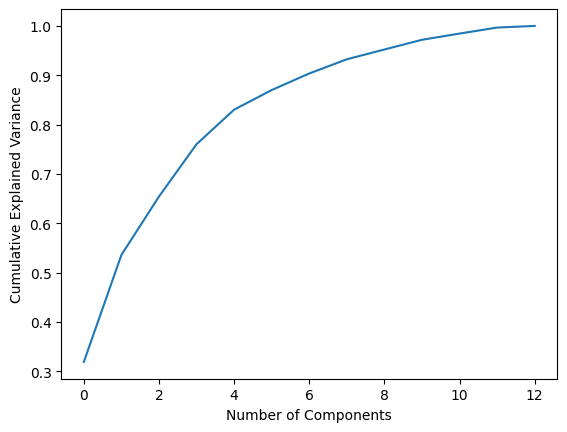

In [77]:
pca = PCA().fit(song_matrix)  
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

#because is a linear transformation technique and can't capture non-linear relationships. same applies to SVD
#better results can be achieved using autoencoders or t-SNE

REDUCING THE DIMENSIONS TO 3

In [82]:
#3 was chosen using the elbow method and it preserves about 85% of the variance of the data
pca = PCA(n_components=3)  
song_matrix_pca = pca.fit_transform(song_matrix)

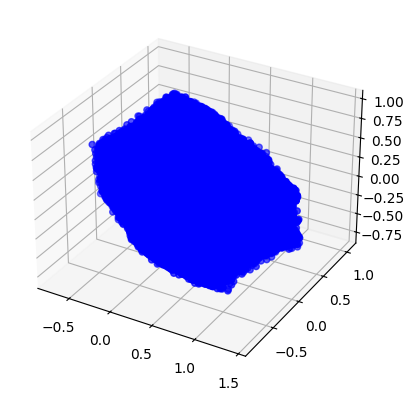

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc1 = song_matrix_pca[:, 0]
pc2 = song_matrix_pca[:, 1]
pc3 = song_matrix_pca[:, 2]

ax.scatter(pc1, pc2, pc3, c='b', marker='o')
plt.show()

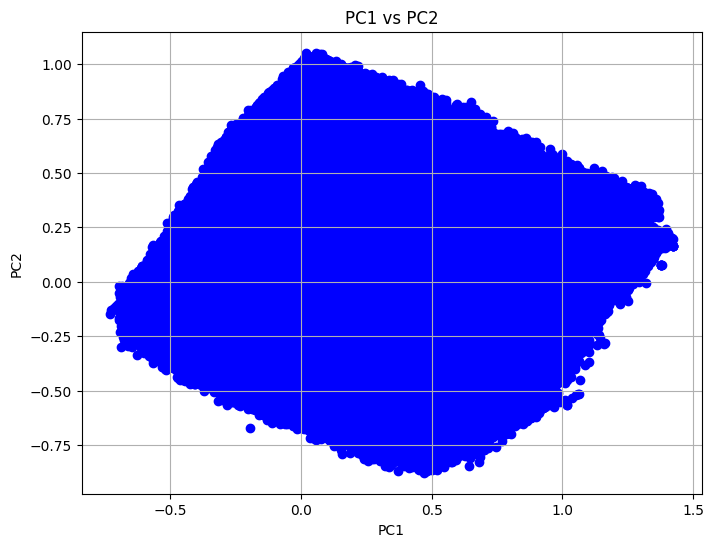

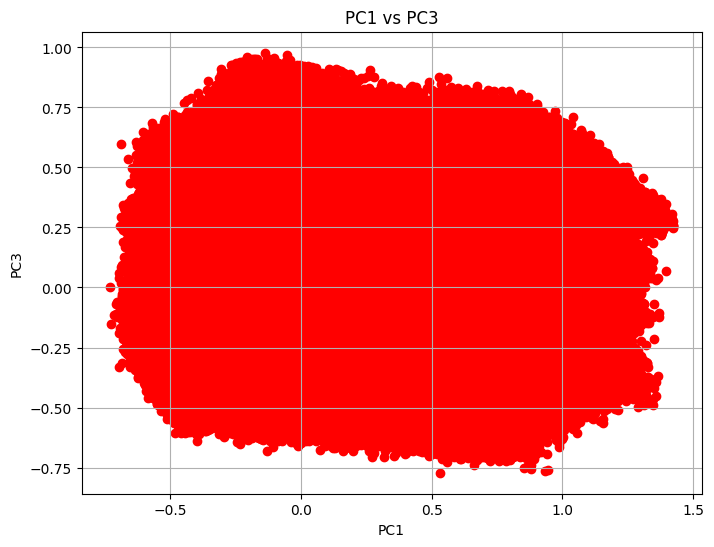

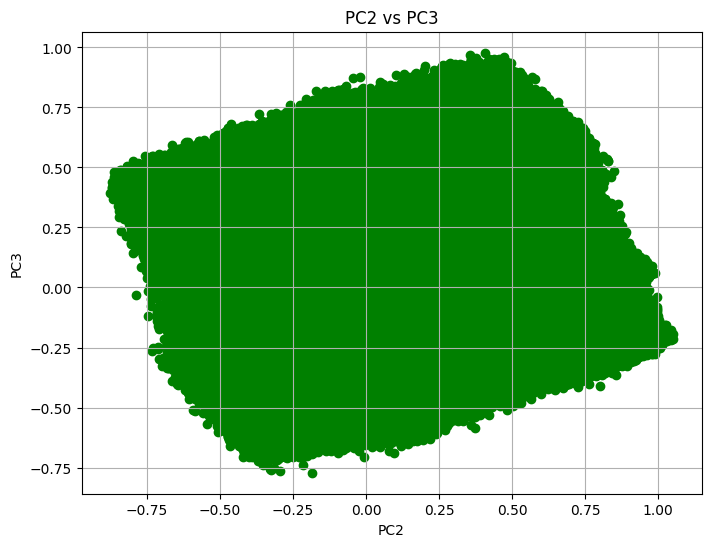

In [38]:
#now do the same thing for 2d
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c='b', marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)
plt.show()

# Second scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc3, c='r', marker='o')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PC1 vs PC3')
plt.grid(True)
plt.show()

# Third scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pc2, pc3, c='g', marker='o')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PC2 vs PC3')
plt.grid(True)
plt.show()

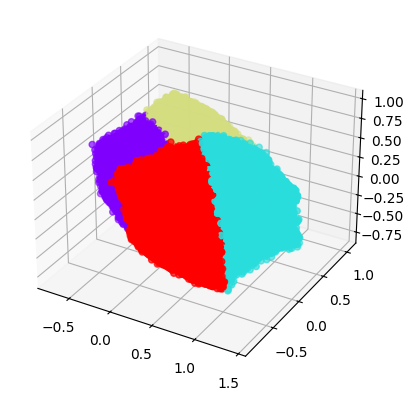

In [43]:
#applying k means clustering to the data

kmeans = KMeans(n_clusters=4)
kmeans.fit(song_matrix_pca)

#visualizing the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pc1, pc2, pc3, c=kmeans.labels_, cmap='rainbow', marker='o')
plt.show()


RECOMMENDING SIMILAR SONGS USING DATA WITH REDUCED DIMENSIONS

In [83]:
try:
    input_song_vector = np.array(df[df['track_id'] == id]['song_vector'].values[0])
except IndexError:
    input_song_vector = unknown_song_vector(id)

input_song_vector = input_song_vector.reshape(1, -1)
input_song_vector_pca = pca.transform(input_song_vector) #transforming the input song vector 
input_song_vector_pca = input_song_vector_pca.reshape(-1)

TOP = 20
similarities = np.dot(song_matrix_pca, input_song_vector_pca) / (song_norms * np.linalg.norm(input_song_vector_pca))
sorted_indices = np.argsort(similarities)[::-1][:TOP]
top_songs = df.loc[sorted_indices, ['track_name', 'artist_name', 'track_id']]
top_songs['similarity'] = similarities[sorted_indices]


mp3_urls = []
spotify_urls = []
image_urls = []
ids = top_songs['track_id'].tolist()
results = sp.tracks(ids)

for track in results['tracks']:
    mp3_urls.append(track['preview_url'])
    spotify_urls.append(track['external_urls']['spotify'])
    image_urls.append(track['album']['images'][0]['url'])
    
top_songs['mp3_url'] = mp3_urls
top_songs['spotify_url'] = spotify_urls
top_songs['image_url'] = image_urls

if id not in ids:
    new_song = pd.DataFrame([{
        'track_name': sp.track(id)['name'],
        'artist_name': sp.track(id)['artists'][0]['name'],
        'track_id': id,
        'similarity': 1,
        'mp3_url': sp.track(id)['preview_url'],
        'spotify_url': sp.track(id)['external_urls']['spotify'],
        'image_url': sp.track(id)['album']['images'][0]['url']
    }])
    top_songs = pd.concat([new_song, top_songs], ignore_index=True)

top_songs

,track_name,artist_name,track_id,similarity,mp3_url,spotify_url,image_url
0,After Hours,The Weeknd,2p8IUWQDrpjuFltbdgLOag,1.000000,None,https://open.spotify.com/track/2p8IUWQDrpjuFlt...,https://i.scdn.co/image/ab67616d0000b2738863bc...
1,ひたむき,SUPER BEAVER,0JtDUkqOV5cRxTdHMXGP3t,0.313405,https://p.scdn.co/mp3-preview/f107a2fa5da866df...,https://open.spotify.com/track/0JtDUkqOV5cRxTd...,https://i.scdn.co/image/ab67616d0000b273a5e2f8...
2,Jalapeño,Big & Rich,5nyczlxrlL02H6v8VqiUBW,0.312592,https://p.scdn.co/mp3-preview/c077ba605421ff1f...,https://open.spotify.com/track/5nyczlxrlL02H6v...,https://i.scdn.co/image/ab67616d0000b273236571...
3,Por Qué No Se Van,Los Prisioneros,2Q81Tu7mnx5g5vfyVPCvCV,0.310084,None,https://open.spotify.com/track/2Q81Tu7mnx5g5vf...,https://i.scdn.co/image/ab67616d0000b273c5246f...
4,Aquí Nadie Esta Sano (feat. Los Auténticos Dec...,Los Amigos Invisibles,4vZdynsnbBJh8WtLmo6wJa,0.309591,https://p.scdn.co/mp3-preview/5dd7710f191837db...,https://open.spotify.com/track/4vZdynsnbBJh8Wt...,https://i.scdn.co/image/ab67616d0000b273b143f3...
5,わかります,Tamio Okuda,5kAqoInjcpwh9csFxajuFy,0.308173,https://p.scdn.co/mp3-preview/07675bce180ad473...,https://open.spotify.com/track/5kAqoInjcpwh9cs...,https://i.scdn.co/image/ab67616d0000b273d5550f...
6,Por Siempre te Alabaré,Planetshakers,3cMINVyTwcZUyK736JaCqq,0.307168,https://p.scdn.co/mp3-preview/027dc5b2f444db0d...,https://open.spotify.com/track/3cMINVyTwcZUyK7...,https://i.scdn.co/image/ab67616d0000b273825edb...
7,おどるポンポコリン,Sakurako Ohara,09TnsucrKhbEU4qQI5dkV0,0.306540,https://p.scdn.co/mp3-preview/0316c22133167458...,https://open.spotify.com/track/09TnsucrKhbEU4q...,https://i.scdn.co/image/ab67616d0000b273d4a736...
8,Señorita a Mi Me Gusta Su Style,Los Rabanes,3L7jB4xMYqApabyWPGlz0g,0.305964,https://p.scdn.co/mp3-preview/2d5316a24d79766a...,https://open.spotify.com/track/3L7jB4xMYqApaby...,https://i.scdn.co/image/ab67616d0000b27325f9ef...
9,風は西から,Tamio Okuda,1wT5yu8yICXbwlr43f2JjE,0.305121,https://p.scdn.co/mp3-preview/15a04b5b348f9b56...,https://open.spotify.com/track/1wT5yu8yICXbwlr...,https://i.scdn.co/image/ab67616d0000b273947f57...


RECOMMENDING SIMILAR SONGS USING APPROXIMATE NEAREST NEIGHBOURS (ANNOY)

In [99]:
length = len(input_song_vector)
annoy_object = AnnoyIndex(length, 'angular') #angular is distance metric suitable for high-dimensional vector comparisons

for i, v in enumerate(song_matrix): 
    annoy_object.add_item(i, v) #i is the song index and v is the song vector
annoy_object.build(10) #10 specifies the number of treesto use in the forest

True

In [100]:
similar_indices = annoy_object.get_nns_by_vector(input_song_vector, TOP) #extracts the nearest neighbors of the input song
top_songs_annoy = df.loc[similar_indices, ['track_name', 'artist_name', 'track_id']]

top_songs_annoy

,track_name,artist_name,track_id
461983,After Hours,The Weeknd,2p8IUWQDrpjuFltbdgLOag
197514,The Hills,The Weeknd,7fBv7CLKzipRk6EC6TWHOB
146769,Her Way,PARTYNEXTDOOR,3JEJwjqLkg2Jbau5922CAb
293461,Don’t Blame Me,Taylor Swift,1R0a2iXumgCiFb7HEZ7gUE
515586,Pray For Me,The Weeknd,6huNf4dutXRjJyGn7f5BPS
612543,Fantasy (feat. Don Toliver),Kali Uchis,1dvqHhLNccePPBHq11TW7v
913867,Chasing Cars,Snow Patrol,5hnyJvgoWiQUYZttV4wXy6
146797,Recognize (feat. Drake),PARTYNEXTDOOR,1DMYEiuAgz1OKvANXiNFrN
146795,18,One Direction,3JjnGLK8IxkNLvo8Lb3KOM
293471,Sign of the Times,Harry Styles,5Ohxk2dO5COHF1krpoPigN
